# Analysis of distribution of shape statistics

This notebook uses indices capturing relationship between shape metrics and area of polygons across all FUAs, identifies peaks and valleys in the distribution using KDE and assesses performance of each shape metric in distinguishing between face polygons and face artifacts.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import json
import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

Set default plotting theme and add color dictionary for continents.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    'Africa': 0, 
    'Asia': 1, 
    'Europe': 2, 
    'North America': 3, 
    'Oceania': 4, 
    'South America': 5}

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)


Set parameters and options for PDF estimation and peak finding; then, generate kernel density estimation (KDE) function for each FUA and each shape metric. Save local minima and maxima ("peaks" and "valleys"), their locations and probability density functions for further analysis.

In [5]:
# set parameters
options = [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]

# parameter for pdf fitting
npoints = 1000

# parameters for peak/valley finding
peak_parameters = {
    "height_mins": numpy.NINF, # no minimal/maximal height for local minima of f (i.e. for peaks of 1-f); setting minimum height to negative inf to nevertheless obtain y-axis peak heights from function
    "height_maxs": 0.008, # minimal height for local maxima of f, to exclude noise; but no maximal height for those peaks
    "prominence": 0.00075} 

In [189]:
# local minima/maxima of KDEs for each FUA and each metric

results = {}

for city in all_poly_data.name.unique():

    # to store results
    results[city] = {}

    # filter for data of only this city
    fua = all_poly_data[all_poly_data.name == city]

    for option in options:
                
        # to store results
        results[city][option] = {}

        # get data for current option, using log of data
        data = numpy.log(fua[option])
        
        # fit Gaussian KDE
        kde = gaussian_kde(data, bw_method="silverman")
        
        # define linear space
        mylinspace = numpy.linspace(data.min(), data.max(), npoints)

        # generate probability density function
        pdf = kde.pdf(mylinspace)

        # find peaks
        peaks, d_peaks = find_peaks(
            x = pdf,
            height = peak_parameters["height_maxs"],
            threshold = None,
            distance = None,
            prominence = peak_parameters["prominence"],
            width = 1,
            plateau_size = None)

        # find valleys
        valleys, d_valleys = find_peaks(
            x = -pdf + 1,
            height = peak_parameters["height_mins"],
            threshold = None,
            distance = None,
            prominence = peak_parameters["prominence"],
            width = 1,
            plateau_size = None)
        
        # store results
        results[city][option]["linspace_params"] = {
            "start": data.min(),
            "stop": data.max(),
            "num": npoints}
        results[city][option]["pdf"] = pdf.tolist()
        results[city][option]["peaks"] = peaks.tolist()
        results[city][option]["d_peaks"] = d_peaks
        results[city][option]["valleys"] = valleys.tolist()
        results[city][option]["d_valleys"] = d_valleys

Now, for each FUA and each metric, check whether the following conditions are fulfilled:
* At least 2 peaks have been found
* At least 1 valley has been found
* There is a peak to the left of the highest peak (i.e. the highest peak is *not* the first peak)
* There is a valley between the highest peak and the left-of-highest peak

If all these conditions are fulfilled, we identify the artefact threshold for the given FUA and given metric as the location of the valley to the left of the highest peak. In case this threshold has been found, we also quantify its power by computing the vertical distance between the highest peak and the valley to its left.

In [190]:
for city in all_poly_data.name.unique():

    for option in options:

        # initially, set threshold and threshold_distance to False
        results[city][option]["threshold"] = False
        results[city][option]["threshold_distance"] = False

        # check if we have at least 2 peaks and at least 1 valley; 
        # also check that the highest peak is not the first one

        condition_2peaks = len(results[city][option]["peaks"]) > 1
        condition_1valley = len(results[city][option]["valleys"]) > 0
        condition_highestnotfirst = numpy.argmax(results[city][option]["d_peaks"]["peak_heights"]) > 0
        conditions = [condition_2peaks, condition_1valley, condition_highestnotfirst]

        if all(conditions):

            # check whether there is exactly one valley between highest and left-from-highest peak
            highest_peak_listindex = numpy.argmax(results[city][option]["d_peaks"]["peak_heights"])

            highest_peak_index = results[city][option]["peaks"][highest_peak_listindex]
            left_peak_index = results[city][option]["peaks"][highest_peak_listindex-1]
            valley_indices = results[city][option]["valleys"]
            valley_indices_between_peaks = [i for i in valley_indices if (i>left_peak_index) and (i<highest_peak_index)]

            if len(valley_indices_between_peaks)==1:
                
                valley_index = valley_indices_between_peaks[0]
                valley_listindex = numpy.where(numpy.array(valley_indices)==valley_index)[0][0]

                # recreate linear space that our indeces refer to
                mylinspace = numpy.linspace(
                    start = results[city][option]["linspace_params"]["start"], 
                    stop = results[city][option]["linspace_params"]["stop"], 
                    num = results[city][option]["linspace_params"]["num"])
                # derive threshold value for given option from index/linspace
                my_threshold = float(numpy.exp(mylinspace[valley_index]))

                results[city][option]["threshold"] = my_threshold

                # compute vertical (y-axis) distance between peak and valley to express power of metric
                mypeak = results[city][option]["d_peaks"]["peak_heights"][highest_peak_listindex]
                myvalley = 1-results[city][option]["d_valleys"]["peak_heights"][valley_listindex]
                mydist = mypeak - myvalley
                results[city][option]["threshold_distance"] = mydist

In [191]:
# remove numpy arrays with not needed data from result dict 
for city in all_poly_data.name.unique():

    for option in options:

        results[city][option]["peak_heights"] = results[city][option]["d_peaks"]["peak_heights"].tolist()
        del results[city][option]["d_peaks"]
        
        results[city][option]["valley_heights"] = results[city][option]["d_valleys"]["peak_heights"].tolist()
        del results[city][option]["d_valleys"]

Save all results so far

In [193]:
with open("../results/04_peaks_results.json", "w") as fp:
    json.dump(results,fp) 

In [3]:
results = json.load(open("../results/04_peaks_results.json"))

**Compare peak results for different metrics**

Brief visual assessment (summary stats of peak finding procedure)

In [27]:
os.makedirs("../plots/peaks/stats", exist_ok=True)
rcParams.update({'figure.autolayout': True})
option_labels = [opt.replace("_", " ") for opt in options]
mybarwidth = 0.5

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_64569/3920157986.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(option_labels, rotation = 90)


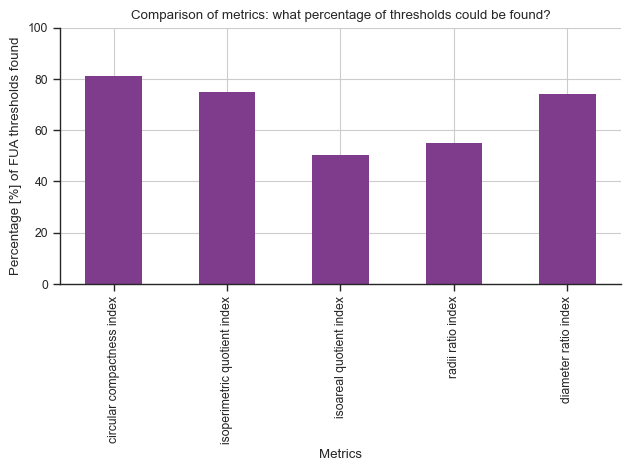

In [33]:
# which metric is most successful at identifying a threshold for each FUA? 

thresholds_found = [sum([results[city][option]["threshold"] != False for city in results.keys()]) for option in options]
thresholds_found_pct = [100* t / len(results.keys()) for t in thresholds_found]

fig, ax = plt.subplots(1,1)
ax.bar(x = option_labels, height = thresholds_found_pct, width = mybarwidth)
ax.set_ylim((0,100))
ax.set_xticklabels(option_labels, rotation = 90)
ax.set_xlabel("Metrics")
ax.set_ylabel("Percentage [%] of FUA thresholds found")
ax.set_title("Comparison of metrics: what percentage of thresholds could be found?");

fig.savefig("../plots/peaks/stats/metric_percentages.png", dpi = 300)

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_64569/2113637070.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(option_labels, rotation = 90)


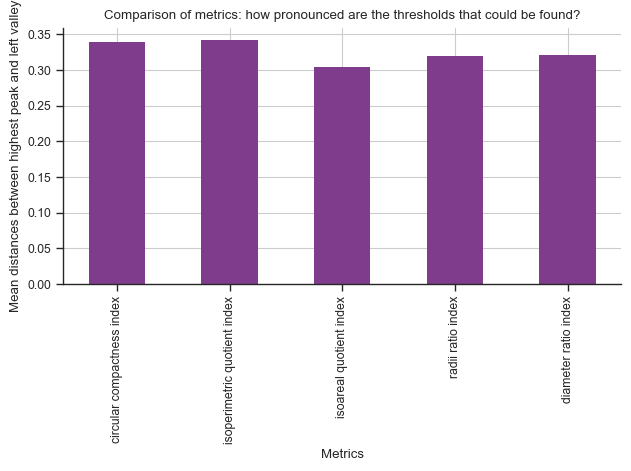

In [31]:
fig, ax = plt.subplots(1,1)

mean_distances_found = [numpy.average([results[city][option]["threshold_distance"] for city in results.keys() if results[city][option]["threshold_distance"] != False]) for option in options]

ax.bar(x = option_labels, height = mean_distances_found, width = mybarwidth)
ax.set_xticklabels(option_labels, rotation = 90)
#ax.set_ylim((0,1))
ax.set_xlabel("Metrics")
ax.set_ylabel("Mean distances between highest peak and left valley")
ax.set_title("Comparison of metrics: how pronounced are the thresholds that could be found?");

fig.savefig("../plots/peaks/stats/metric_thresholds.png", dpi = 300)

***